In [1]:
# Load Packages
import pandas as pd
import numpy as np
import plotly.express as px

import warnings
from typing import List
import os, sys, time

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import keras

rootpath = ".."
sys.path.insert(0, f"{os.getcwd()}/{rootpath}/base_models")
sys.path.insert(0, f"{os.getcwd()}/{rootpath}/source_models")
warnings.filterwarnings("ignore")

import model_prep

season_map = {
    "spring": [3, 4, 5],
    "summer": [6, 7, 8],
    "fall": [9, 10, 11],
    "winter": [12, 1, 2],
}

2023-12-02 21:41:44.589334: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from_building_name = "Kissam"
from_tower_number = 2
to_building_name = "ESB"
to_tower_number = 1
features = ['FlowEvap', 'PerHumidity', 'TempAmbient', 'TempCondIn',
    'TempCondOut', 'TempEvapIn', 'TempEvapOut', 'TempWetBulb',
    'PerFreqConP', 'Tonnage', 'PerFreqFan']
target = 'EnergyConsumption'
to_season = "fall"
from_season = "summer"
finetuning_percentage = 0.8
source_epochs=100
finetune_epochs = 100
display_results = True
use_delta = False
shuffle_seed = 42
train_percentage = 0.8

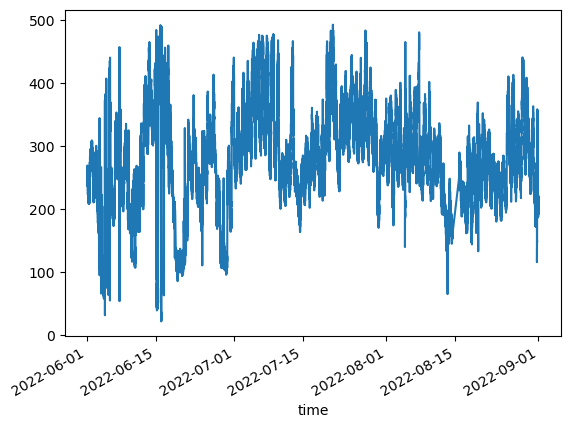

In [3]:
"""
1. Load data and do basic preprocessing
"""
# load data
df = pd.read_csv(
    f"{rootpath}/data/{from_building_name.lower()}/{from_building_name.lower()}{from_tower_number}_preprocessed.csv",
    index_col="time",
)
df.index = pd.to_datetime(df.index)

# only take data for one season
df = model_prep.choose_season(df, season=from_season)

# remove cases in which tower was OFF, and cases where OFF data would be included in past timesteps of ON data
on_condition = df[target] > 0
df = df.drop(df[~on_condition].index, axis=0)

# select features and targets and create final dataframe that includes only relevant features and targets
df = df[features+["DayOfWeek"]].join(df[target], on=df.index)

df[target].plot()

# if difference from first value should be used as for predictions then return the first value
first_val = df.iloc[0, df.columns.get_loc(target)]
if use_delta:
    df[target] = (
        df[target] - first_val
    )

In [4]:
"""
2. Seasonality removal
"""

def calculate_seasonal_index(time_series, seasonality_column, m):
    """
    Calculate the seasonal index for each seasonality value in the time series.

    Parameters:
    - time_series: Pandas DataFrame containing the time series data with a column for the seasonality values.
    - seasonality_column: String representing the column name containing the seasonality values (e.g., days of the week).
    - m: Integer representing the number of data points for each seasonality value.

    Returns:
    - Pandas DataFrame containing the seasonal index for each seasonality value.
    """

    # Group the data by the seasonality column
    grouped_data = time_series.groupby(seasonality_column)

    # Calculate the average of all target variable data points
    y_bar = time_series.mean()[target]

    # Initialize an empty dictionary to store the seasonal index values
    seasonal_index_dict = {}

    # Iterate through each group (seasonality value)
    for group, group_data in grouped_data:
        # Calculate the sum of the first m data points
        sum_y_p_j = group_data.iloc[:m][target].sum()

        # Calculate the seasonal index using the provided formula
        seasonal_index = 1 / y_bar * (1 / m) * sum_y_p_j

        # Store the seasonal index value in the dictionary
        seasonal_index_dict[group] = seasonal_index

    # Convert the dictionary to a Pandas DataFrame
    seasonal_index_df = pd.DataFrame(list(seasonal_index_dict.items()), columns=[seasonality_column, 'sp'])

    return seasonal_index_df

def operate_with_sp(col, sp_df, operation):
    index_col = col.index
    combined_df = pd.merge(col, sp_df, left_on=col.index.dayofweek, right_on='DayOfWeek', how='left').set_index(index_col)
    if operation == 'multiply':
        combined_df[col.name] = combined_df[col.name] * combined_df['sp']
    elif operation == 'divide':
        combined_df[col.name] = combined_df[col.name] / combined_df['sp']
    else:
        raise ValueError('Invalid operation')
    return combined_df[col.name]

   DayOfWeek        sp
0          0  1.026562
1          1  0.934045
2          2  1.075698
3          3  0.988572
4          4  1.118081
5          5  1.024066
6          6  1.021607


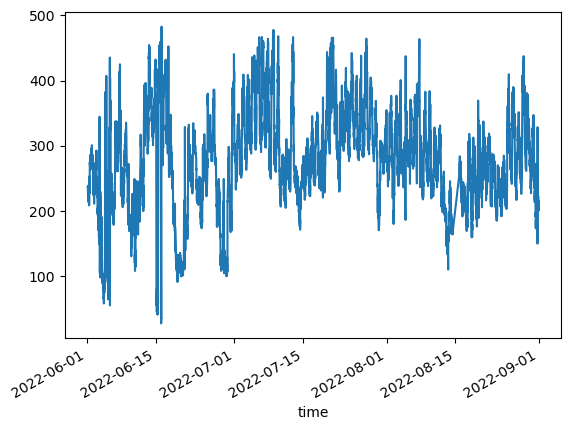

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
        df[features+["DayOfWeek"]], df[target], test_size=(1 - train_percentage), shuffle=True, random_state=shuffle_seed
    )
train_set = X_train.merge(y_train, how="left", left_index=True, right_index=True)
test_set = X_test.merge(y_test, how="left", left_index=True, right_index=True)

# apply seasonality removal
sdf = calculate_seasonal_index(train_set, 'DayOfWeek', 7)
train_set[target] = operate_with_sp(col=train_set[target], sp_df=sdf, operation="divide")

print(sdf)

# Split further
X_train, X_test = train_set[features], test_set[features]
y_train, y_test = train_set[target], test_set[target]

y_test.plot()

# scale feature data - use source domain scaler
scaler = MinMaxScaler().fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

vec_X_train = X_train.values
vec_X_test = X_test.values
vec_y_train = y_train.values
vec_y_test = y_test.values

In [6]:
from keras.models import Sequential
from keras.layers import Dense


# Build the MLP model
model = Sequential()
model.add(Dense(80, input_shape=(len(features),), kernel_initializer='normal', activation='relu'))
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(vec_X_train, vec_y_train, epochs=200, batch_size=10, verbose=0)

2023-12-02 21:41:48.149443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


162/162 [==============================] - 0s 480us/step


<Axes: xlabel='time'>

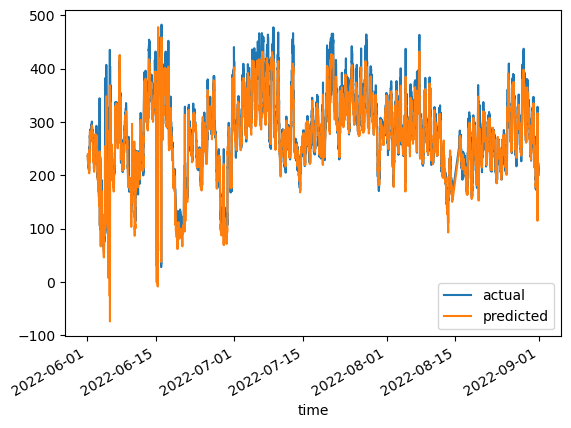

In [7]:
# Evaluate the model
y_pred = model.predict(vec_X_test)

# Evaluate the model

results_df = pd.DataFrame(
    {
        "actual": vec_y_test.reshape((vec_y_test.shape[0])),
        "predicted": y_pred.reshape((y_pred.shape[0])),
    },
    index=y_test.index,
)

results_df.plot()

In [8]:
# invert seasonality removal
if not use_delta: first_val = 0
results_df['actual'] = operate_with_sp(results_df['actual'], sdf, 'multiply') + first_val
results_df['predicted'] = operate_with_sp(results_df['predicted'], sdf, 'multiply') + first_val

mae = mean_absolute_error(results_df['actual'], results_df['predicted'])
print(f"Mean Absolute Error: {mae}")

# Plot the results
display_df = pd.DataFrame(
    index=pd.date_range(
        start=results_df.index.min(), end=results_df.index.max(), freq="5min"
    )
).merge(results_df, how="left", left_index=True, right_index=True)


fig = px.line(display_df, x=display_df.index, y=["actual", "predicted"])
fig

Mean Absolute Error: 12.748132172144931


# Transfer Logic

In [9]:
"""
1. Load data and do basic preprocessing
"""
# load data
df = pd.read_csv(
    f"{rootpath}/data/{to_building_name.lower()}/{to_building_name.lower()}{to_tower_number}_preprocessed.csv",
    index_col="time",
)
df.index = pd.to_datetime(df.index)

# only take data for one season
df = model_prep.choose_season(df, season=from_season)

# remove cases in which tower was OFF, and cases where OFF data would be included in past timesteps of ON data
on_condition = df[target] > 0
df = df.drop(df[~on_condition].index, axis=0)

# select features and targets and create final dataframe that includes only relevant features and targets
df = df[features + ["DayOfWeek"]].join(df[target], on=df.index)

In [10]:
"""
3. Split data into training and testing sets
"""

X_train, X_test, y_train, y_test = train_test_split(
        df[features+["DayOfWeek"]], df[target], test_size=(1 - train_percentage), shuffle=True, random_state=shuffle_seed
    )
train_set = X_train.merge(y_train, how="left", left_index=True, right_index=True)
test_set = X_test.merge(y_test, how="left", left_index=True, right_index=True)

# apply seasonality removal
sdf = calculate_seasonal_index(train_set, 'DayOfWeek', 7)
train_set[target] = operate_with_sp(col=train_set[target], sp_df=sdf, operation="divide")

In [11]:
# Split further
X_train, X_test = train_set[features], test_set[features]
y_train, y_test = train_set[target], test_set[target]

# scale feature data
scaler = MinMaxScaler().fit(X_train)
X_train[X_train.columns] = scaler.transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)
vec_X_train = X_train.values
vec_X_test = X_test.values


vec_y_train = y_train.values
vec_y_test = y_test.values

In [12]:
history = model.fit(vec_X_train, vec_y_train, epochs=100, batch_size=10, verbose=0)

In [13]:
# Evaluate the model
y_pred = model.predict(vec_X_test)

# Evaluate the model

results_df = pd.DataFrame(
    {
        "actual": vec_y_test.reshape((vec_y_test.shape[0])),
        "predicted": y_pred.reshape((y_pred.shape[0])),
    },
    index=y_test.index,
)

# invert seasonality removal
results_df['actual'] = operate_with_sp(results_df['actual'], sdf, 'multiply')
results_df['predicted'] = operate_with_sp(results_df['predicted'], sdf, 'multiply')

mae = mean_absolute_error(results_df['actual'], results_df['predicted'])
print(f"Mean Absolute Error: {mae}")

# Plot the results
display_df = pd.DataFrame(
    index=pd.date_range(
        start=results_df.index.min(), end=results_df.index.max(), freq="5min"
    )
).merge(results_df, how="left", left_index=True, right_index=True)


fig = px.line(display_df, x=display_df.index, y=["actual", "predicted"])
fig

91/91 [==============================] - 0s 475us/step
Mean Absolute Error: 15.240593525094809
